# NBA Player Value

This notebook seeks to model NBA player salaries by identifying valuable performance statistics that are predictive of monetary value (at least in the eyes of NBA general managers)

In [1]:
# Imports + Setup
library(tidyverse)
library(MASS)
library(kableExtra)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select



Attaching package: ‘kableExtra’


The following object is masked from ‘package:dplyr’:

    group_rows




In [2]:
# Read in CSV from .py script
nba <- read_csv("./stats_and_salaires.csv")                               

# Custom histogram function
fastHistogram <- function(FEAT, NAME, BINS=30) {
        nba %>% ggplot(aes(x = scale(FEAT))) +
                geom_histogram(color="white", bins = BINS, fill="royalblue4", alpha=0.92) +
                labs(x = paste("Scaled Feature: ", NAME), y = "") +
                theme_minimal()
}

Parsed with column specification:
cols(
  .default = col_double(),
  Player = col_character(),
  Pos = col_character(),
  Tm = col_character(),
  Salary = col_character()
)

See spec(...) for full column specifications.



In [3]:
head(nba)

Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,⋯,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Salary
<dbl>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,Steven Adams,C,26,OKC,63,63,1680,283,478,⋯,207,376,583,146,51,67,94,122,684,"$25,842,697"
2,Bam Adebayo,PF,22,MIA,72,72,2417,440,790,⋯,176,559,735,368,82,93,204,182,1146,"$3,454,080"
3,LaMarcus Aldridge,C,34,SAS,53,53,1754,391,793,⋯,103,289,392,129,36,87,74,128,1001,"$26,000,000"
5,Nickeil Alexander-Walker,SG,21,NOP,47,1,591,98,266,⋯,9,75,84,89,17,8,54,57,267,"$2,964,840"
6,Grayson Allen,SG,24,MEM,38,0,718,117,251,⋯,8,77,85,52,10,2,33,53,330,"$2,429,400"
7,Jarrett Allen,C,21,BRK,70,64,1852,302,465,⋯,216,455,671,110,40,92,77,162,775,"$2,376,840"


-----------

## Data Cleaning + Transformation

* We'll convert the Salary feature to a numeric value by stripping the leading **$ sign**

* **Points Per Minute** and **Assists Per Minute** can be considered proxies for a player's relative offensive impact on the floor

In [4]:
nba$Salary <- as.numeric(gsub("[\\$,]", "", nba$Salary))        # Convert salary to int value

nba <- nba %>% 
        mutate("PPM" = PTS / MP, "APM" = AST/MP)                # Calculate Points and Assists / Minute
        

# Numeric variables only
nba.reduced <- nba %>% 
        dplyr::select(!c("Rk", "Player", "Tm", "Pos")) %>% 
        na.omit()


nba  %>% arrange(desc(Salary))  %>% head()

Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,⋯,TRB,AST,STL,BLK,TOV,PF,PTS,Salary,PPM,APM
<dbl>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
121,Stephen Curry,PG,31,GSW,5,5,139,33,82,⋯,26,33,5,2,16,11,104,40231758,0.7482014,0.2374101
396,Chris Paul,PG,34,OKC,70,70,2208,434,887,⋯,349,472,111,11,161,158,1232,38506482,0.5579710,0.2137681
506,Russell Westbrook,PG,31,HOU,57,57,2049,604,1281,⋯,451,401,93,20,255,200,1553,38178000,0.7579307,0.1957052
198,James Harden,SG,30,HOU,68,68,2483,672,1514,⋯,446,512,125,60,308,227,2335,37800000,0.9403947,0.2062022
250,LeBron James,PG,35,LAL,67,67,2316,643,1303,⋯,525,684,78,36,261,118,1698,37436858,0.7331606,0.2953368
190,Blake Griffin,PF,30,DET,18,18,512,88,250,⋯,84,59,7,7,40,27,279,34234964,0.5449219,0.1152344


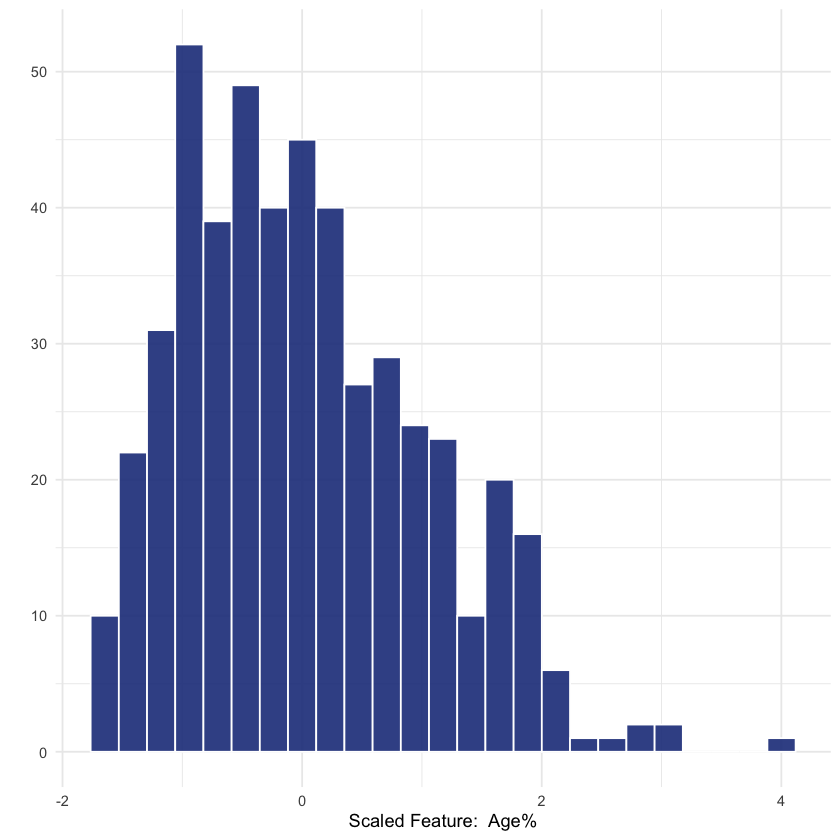

In [5]:
# Plot Age distribution
fastHistogram(nba$Age, "Age%", 25)

After scaling `Age`, it’s evident that this distribution is slightly right-skewed (in other words, the majority of the data falls below the mean). We’ll attempt to log-transform this variable to approximate normality, though if the transformation yields any infinite values, we won’t be able to effectively perform the log-transform.

Warning message:
“Removed 23 rows containing non-finite values (stat_bin).”


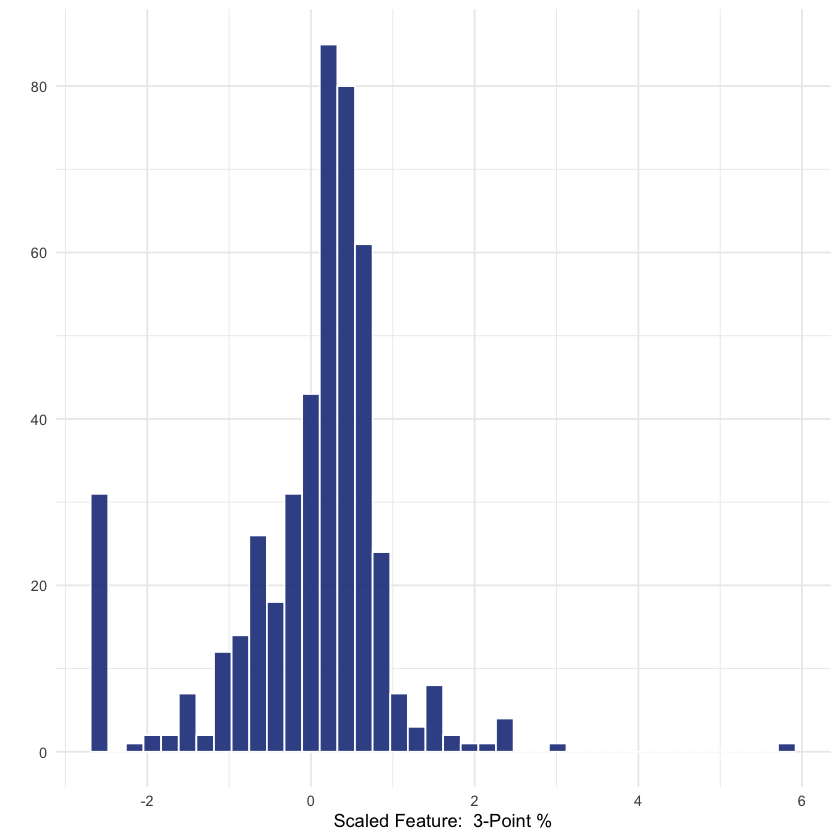

In [6]:
# Plot 3P%
fastHistogram(nba$`3P%`, "3-Point %", 40)

`3-Point%` is slightly left-skewed, and seems to have several severe outliers. This most likely represents low-volume shooters (for example, players that take and make one 3-pointer would be an extreme outlier). We likely will not need to transform this variable, as a log-transformation will not impact the extreme positive outliers observed here. 

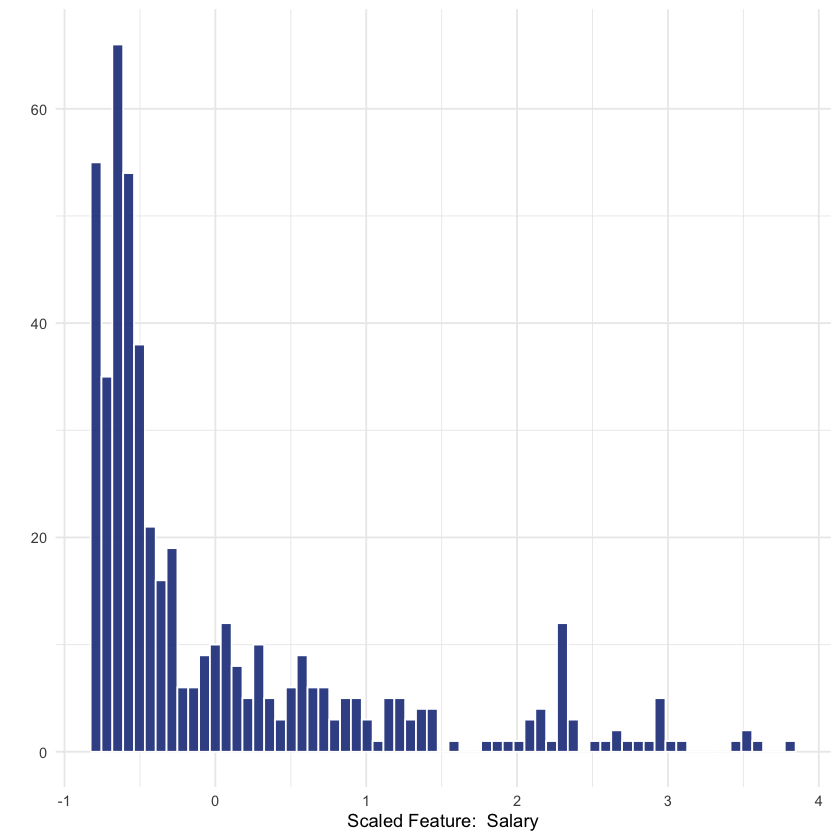

In [7]:
# Plot salary distribution
fastHistogram(nba$Salary, "Salary", 65)

Salary is observed to be **massively right-skewed**, such that the majority of observations are less than the mean average of the total distribution. There are noticeable outliers in this distribution, with several observations 3 or more standard deviations from the mean. This is a good indicator that, to obtain a robust result, we’ll need to log-transform player salaries in our linear model. 

----------

## Modeling

This first model will include **all numeric features**

In [8]:
base.model <- lm(log(Salary) ~ ., data = nba.reduced)              # Build model with all features
summary(base.model)


Call:
lm(formula = log(Salary) ~ ., data = nba.reduced)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.5404 -0.5621  0.1341  0.6027  2.7984 

Coefficients: (4 not defined because of singularities)
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  9.8155592  0.6528291  15.035  < 2e-16 ***
Age          0.0885062  0.0124307   7.120 4.52e-12 ***
G            0.0032012  0.0063204   0.506  0.61278    
GS           0.0075837  0.0041433   1.830  0.06788 .  
MP           0.0005156  0.0004468   1.154  0.24912    
FG          -0.0055923  0.0043162  -1.296  0.19579    
FGA          0.0032690  0.0023541   1.389  0.16566    
`FG%`        2.6322491  2.6706998   0.986  0.32488    
`3P`        -0.0109322  0.0096758  -1.130  0.25917    
`3PA`        0.0040632  0.0042782   0.950  0.34278    
`3P%`       -0.1430373  0.6423240  -0.223  0.82388    
`2P`                NA         NA      NA       NA    
`2PA`               NA         NA      NA       NA    
`2P%`       -0.0991689 

The **coefficients** in the base model appear to be weakly predictive, at best. This is due in part to the combination of variables. To yield a better, more predictive model, we’re going to employ **AIC Stepwise Variable Selection** to incorporate different combinations of variables, with our final model containing the most robust set of predictors. 

In [9]:
# Log-transform points and 2-point attempts
base.model <- stats::update(base.model, . ~ . -PTS +log(PTS) -`2PA` +log(`2PA`))

# Select optimal variables via AIC stepwise selection
step.model <- MASS::stepAIC(base.model, 
                            direction = "both",
                            k = 2,
                            trace = F, 
                            steps = 1000)

summary(step.model)


Call:
lm(formula = log(Salary) ~ Age + G + GS + `3PA` + `3P%` + DRB + 
    BLK + PF + PPM + log(PTS) + log(`2PA`), data = nba.reduced)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.1788 -0.5143  0.0926  0.6360  2.5933 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  9.4874297  0.4174365  22.728  < 2e-16 ***
Age          0.0892103  0.0111422   8.007 1.03e-14 ***
G           -0.0196441  0.0056865  -3.455 0.000604 ***
GS           0.0072090  0.0031960   2.256 0.024577 *  
`3PA`        0.0012574  0.0005821   2.160 0.031287 *  
`3P%`       -0.7780925  0.4574522  -1.701 0.089654 .  
DRB          0.0014193  0.0007888   1.799 0.072659 .  
BLK          0.0042139  0.0028165   1.496 0.135325    
PF          -0.0044225  0.0019183  -2.305 0.021598 *  
PPM         -0.7216156  0.4785376  -1.508 0.132273    
log(PTS)     0.3719284  0.1918988   1.938 0.053236 .  
log(`2PA`)   0.4795238  0.1613333   2.972 0.003116 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0

Our AIC selection algorithm yields an interesting set of predictors. We observe an R-squared value of 0.4414; put simply, our model accounts for **44.14% of the variance in player salary**. Considering the swath of variance that we can’t account for given the present data (injury, market value, salary cap, etc.) this is actually pretty decent! Let’s apply this finished model to our full dataset to see how teams and players fare. 

-----------

## Predictions

Now that we have an optimized model, let’s apply it to our data. This will give us a `PREDICTIONS` column, which represents an estimation of what each player should be paid based on their individual stat lines.

`geom_smooth()` using method = 'loess' and formula 'y ~ x'

Warning message:
“Removed 23 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 23 rows containing missing values (geom_point).”


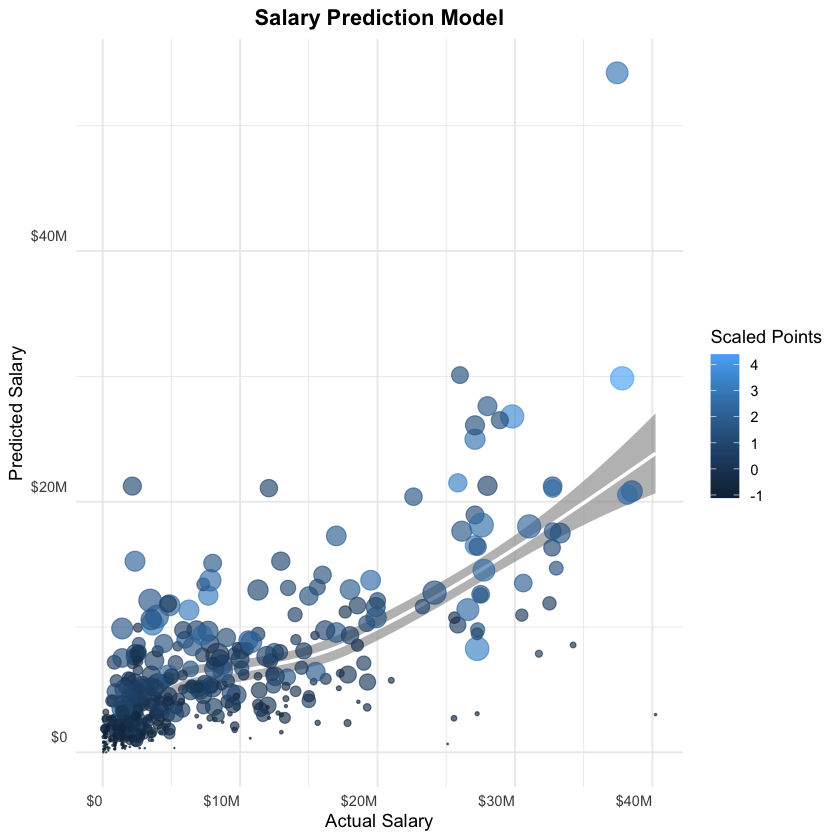

In [10]:
# Predict salaries with our optimal model
nba["PREDICTIONS"] <- exp(predict(step.model, nba))


# Define custom X + Y labels
x_labels <- c("$0", "$10M", "$20M", "$30M", "$40M")
y_labels <- c("$0", "$20M", "$40M", "$60M")


# Plot actual vs. predicted salaries
salary.plot <- nba %>%
                        ggplot(aes(x = Salary, y = PREDICTIONS, color=scale(PTS))) +
                        geom_smooth(color="white", alpha=0.65) +
                        geom_point(alpha=0.65, size=(nba$MP / 400)) +
                        theme_minimal() +
                        labs(x = "Actual Salary", 
                             y = "Predicted Salary",
                             title = "Salary Prediction Model",
                             color = "Scaled Points") +
                        theme(plot.title = element_text(hjust = 0.5, face="bold")) +
        scale_x_continuous(labels = x_labels) + scale_y_continuous(labels = y_labels) +
        theme(axis.text.x = element_text(hjust = 1),
              axis.text.y = element_text(vjust = -1))


salary.plot

We observe a moderately close fit between the the observed data points and the line of best fit in this plot. While there appears to be a general trend of points scored correlating with salary, this model seems to inflate player salaries slightly, such that players’ predicted salaries tend to be higher than their actual salaries. This is most likely due to the lack of control parameters built in to this model (for example, salary cap is not enforced in this environment, which provides no ceiling for the model to work under).

-----------

# Determining Player Value

*How will this work?*

Using the predicted values from our model, we’ll calculate the differential from actual salaries to create a `Salary.Differential` variable. If this variable is positive - i.e., the predicted salary is higher than the actual salary - we may assert that this player is **underpaid**. Conversely, if the predicted salary is lower than the actual salary, it would suggest that the player is **overpaid**.

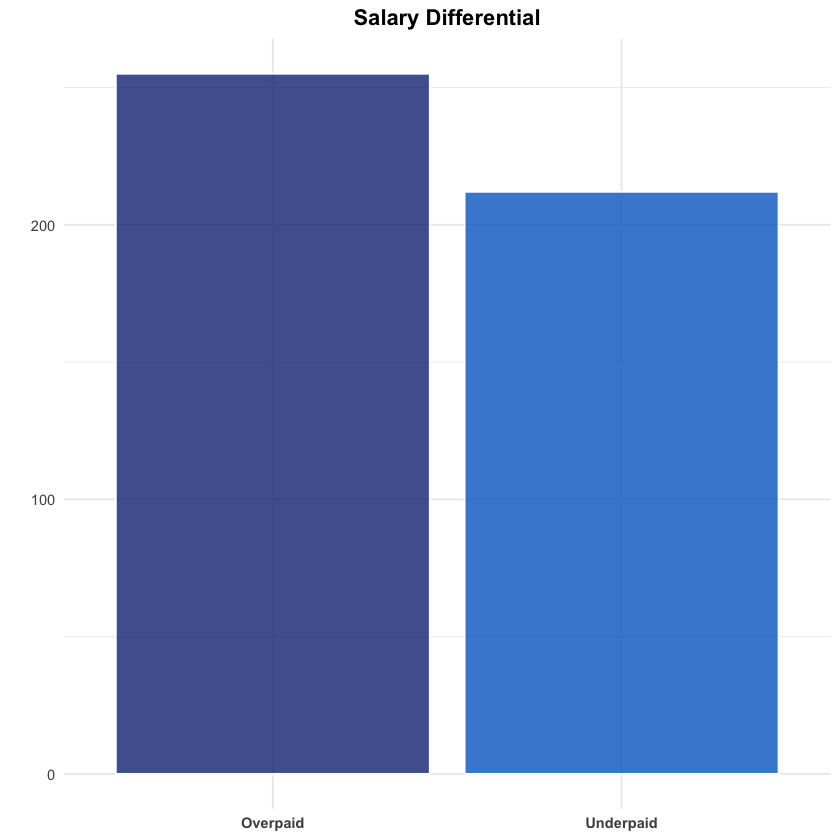

In [11]:
nba <- nba %>%
        mutate("Salary.Differntial" = PREDICTIONS - Salary,
               "Overpaid" = ifelse(Salary.Differntial < 0, "Overpaid", "Underpaid"))


nba %>% 
        dplyr::filter(Overpaid != "NA") %>% 
        ggplot(aes(x = Overpaid, fill=Overpaid)) +
        geom_bar(color="white", alpha=0.85) +
        labs(x = "Salary Differential", 
             y ="",
             title = "Salary Differential") +
        theme_minimal() +
        theme(legend.position = "none",
              axis.title.x = element_blank(),
              axis.text.x = element_text(face="bold"),
              plot.title = element_text(face = "bold", hjust = 0.5)) +
        scale_fill_manual(values = c("royalblue4", "dodgerblue3"))

---------

## Underpaid Players

First, let’s look at players whose projected salaries are **higher** than what they are actually paid. We’ll consider these players **underpaid**:

In [12]:
nba %>%
        dplyr::select(Player, Age, Salary, PREDICTIONS, Salary.Differntial) %>% 
        arrange(desc(Salary.Differntial)) %>% 
        head(10)

Player,Age,Salary,PREDICTIONS,Salary.Differntial
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Carmelo Anthony,35,2159029,21243192,19084163
LeBron James,35,37436858,54224965,16788107
Pascal Siakam,25,2351839,15248768,12896929
Brook Lopez,31,12093024,21079204,8986180
Bam Adebayo,22,3454080,12115621,8661541
Devonte' Graham,24,1416852,9879723,8462871
Vince Carter,43,2564753,9947336,7382583
Lou Williams,33,8000000,15096260,7096260
Garrett Temple,33,4767000,11844826,7077826


**Obvious points**: You can’t overpay LeBron James. Whatever the league will allow you to pay him, pay him 150% of that. Similarly, the other players on this list include Luka, Siakam, and Bam Adebayo - in other words, young players who either haven’t hit the bank yet or are playing above their value.



**Less obvious**: Carmelo’s inclusion on this list. Our model indicates that his stat line should have put him around the `$16M / year` range. His actual salary is relatively modest in comparison, which makes him a bit of a bargain.

----------

## Overpaid Players

Here we’ll take the opposite approach, and explore players whose predicted salaries are less than their actual salaries. We’ll filter out **Steph Curry** since he was injured all year and makes lots of money. An outlier if ever there was one

In [13]:
nba %>%
        dplyr::select(Player, Age, Salary, PREDICTIONS, Salary.Differntial) %>% 
        dplyr::filter(Player != "Stephen Curry") %>% 
        arrange((Salary.Differntial)) %>% 
        head(10)

Player,Age,Salary,PREDICTIONS,Salary.Differntial
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Blake Griffin,30,34234964,8563037.7,-25671926
Chandler Parsons,31,25102511,665621.4,-24436890
Otto Porter,26,27250576,3078809.6,-24171766
Kyrie Irving,27,31742000,7867312.0,-23874688
Nicolas Batum,31,25565217,2715421.6,-22849795
Mike Conley,32,32511623,11889613.1,-20622010
Paul Millsap,34,30500000,10947595.5,-19552405
Devin Booker,23,27250000,8263049.8,-18986950
Paul George,29,33005556,14692538.7,-18313017


**Obvious points**: Relative to the underpaid player list, the majority of these players are in their late 20’s and early 30’s. This point is twofold - older players are more likely to have higher salaries (i.e., non-rookie deals), and older players are generally less likely to have robust stat lines relative to younger players (see: Blake Griffin on both accounts).



**Less obvious**: Westbrook (57 games played) and Kyrie (20 games played). The Westbrook outcome is especially interesting - it’d be interesting to approach this question slightly differently, to see how Westbrook stacks up in years that he plays the full season. He’s a former MVP, but he can easily drop to a below-average player at times. Surely this has been quantified by other researchers, but still worth a shot!

---------

## Team Cap Management

Lastly, let’s track how teams look overall - how many of their players are **overpaid** and how many of their teams are **underpaid**. We’ll calculate the percentage of each roster that is made up of overpaid players, then we’ll observe the “bottom 10” - i.e., the 10 teams that have the highest percentage of overpaid players.

In [14]:
nba %>% 
        group_by(Tm) %>% 
        filter(Tm != "TOT") %>% 
        summarise(Players = n(),
                  Underpaid.Players = sum(Overpaid == "Underpaid", na.rm = T),
                  Overpaid.Players = sum(Overpaid == "Overpaid", na.rm = T),
                  Pct.Overpaid = (Overpaid.Players / Players)) %>% 
        head(10) %>% 
        arrange(desc(Pct.Overpaid))

`summarise()` ungrouping output (override with `.groups` argument)



Tm,Players,Underpaid.Players,Overpaid.Players,Pct.Overpaid
<chr>,<int>,<int>,<int>,<dbl>
CHI,15,4,10,0.6666667
DAL,13,5,8,0.6153846
DEN,11,5,6,0.5454545
BOS,15,6,8,0.5333333
DET,12,6,6,0.5000000
ATL,13,7,6,0.4615385
CHO,14,9,4,0.2857143
CLE,14,7,4,0.2857143
GSW,16,12,4,0.2500000


Seems to be a bit of a mixed bag, just by the eye test. Of the bottom-10 teams with a high-percentage of overpaid players, some of them are competitive - Dallas, Boston, Denver - while others are competing for the lottery every year (such as Cleveland and Detroit). Intuitively, it seems like it’s more important to pay the right players, even if those players are large cap expenditures.



Dallas is a good example of this, as they’re able to get amazing output from Luka while only paying him ~$7M annually.

In [15]:
nba %>% 
        dplyr::filter(Tm == "DAL") %>% 
        dplyr::select(Player, Age, Pos, Salary) %>% 
        arrange(desc(Salary)) %>% head(5)

Player,Age,Pos,Salary
<chr>,<dbl>,<chr>,<dbl>
Kristaps Porziņģis,24,PF,27285000
Courtney Lee,34,SG,12759670
Dwight Powell,28,C,10259375
Delon Wright,27,SG,9473684
Maxi Kleber,28,C,8000000


--------

# Future Directions

* Calculate the correlation between “overpaid player percentage” and win total in the regular season

* Fix the dataset to minimize `NA` values in the model (and, in turn, yield a higher R-squared value)


<img src="https://media.newyorker.com/photos/60b10421d60710aaa9f4959a/master/pass/RH-SpikeLee-2560.png" width=50%>